In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_oscillation
from neurodsp.spectral import compute_spectrum

from statsmodels.tsa.stattools import acf

from timescales.sim import sim_branching
from timescales.autoreg import compute_ar_spectrum
from timescales.fit import PSD, ACF

from ndspflow import WorkFlow, Param
from tqdm.notebook import tqdm

# Evaluating Timescale Estimates

There are several decisions that are required to measure a signal's timescales, including method, model, and hyperparmeters. This notebook explores a few methods to examine how they perform, in terms of timescale estimation error, across hyperparameters.

- Autoregressive models
- Welch's PSD
- ACF

For each method, a grid of parameters spefic to the model type are used to fit branching simulations.

## Parameter Grid

Set up a grid of parameters for AR order, Welch's window size, and number of lags in the ACF. Simulated timescales are sampled uniformly from 1 to 40 Hertz.

In [2]:
# Simulation
n_seconds = 1
fs = 1000

def sim_tau(n_seconds, fs):
    
    tau = 1 / (2 * np.pi * np.random.uniform(1, 40))
    osc_freq = np.random.uniform(1, 80)

    sig_ap = sim_branching(n_seconds, fs, tau, 1000, mean=0, variance=0.8)
    sig_pe = sim_oscillation(n_seconds, fs, osc_freq, mean=0, variance=0.2)
    
    return sig_ap + sig_pe
    
# Simulation random seeds
seeds = np.arange(1000)

# Welch parameters
nperseg = np.arange(100, int(fs*n_seconds)//2+25 + 75, 5)

# AR parmameters
order = np.arange(2, 202, 2)

# ACF
nlags = np.arange(2, 202, 2)

def compute_acf(sig, nlags):
    corrs = acf(sig, nlags=nlags)
    lags = np.arange(nlags+1)
    return lags, corrs

## Workflow

Use `ndspflow` to simulate, compute PSD and ACF, and fit the corresponding model to estimate the timescale. `ndspflow` is a package that allows for full construction of analysis pipelines or workflows. Input data may either be simulated or real, and outputs may be a model, statistic, or parmeters.

Here `.simulate` is used to simulate data, `.transform` is used to compute either the PSD or ACF, and `.fit` is used to fit the model. Workflow can be split or forked to allow alternative paths the data can pass through and the `Param` class is used to perform grid-searches. When fitting with `.fit` entire workflows are parallelized efficiently.

The methods and associated parameters are:

- AR PSD, ar_order
- Welch's PSD, window length
- ACF, number of lags

In [3]:
wf = WorkFlow(seeds=seeds)

wf.simulate(sim_tau, n_seconds, fs)

# AR PSD
wf.fork(0)
wf.transform(compute_ar_spectrum, fs, Param(order))
wf.fit(PSD())

# Welch's PSD
wf.fork(0)
wf.transform(compute_spectrum, fs, nperseg=Param(nperseg))
wf.fit(PSD())

# ACF
wf.fork(0)
wf.transform(compute_acf, nlags=Param(nlags))
wf.fit(ACF(fs=fs), maxfev=2000)

wf.run(n_jobs=-1, progress=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Plot Results

Results are oranganized as (simulation_index, fork_index, parameter_index). Below we plot one of each model type for the min and max parameter (e.g. ar order).

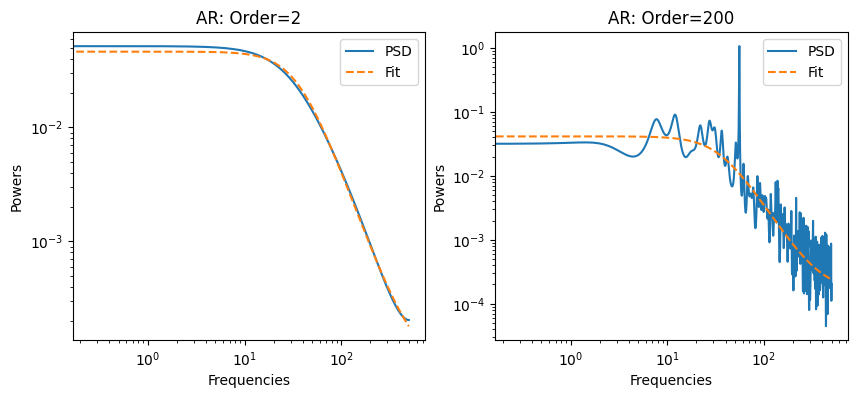

In [4]:
# AR
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

wf.results[0][0][0].plot(ax=axes[0])
wf.results[0][0][-1].plot(ax=axes[1])

axes[0].set_title(f"AR: Order={order[0]}")
axes[1].set_title(f"AR: Order={order[-1]}");

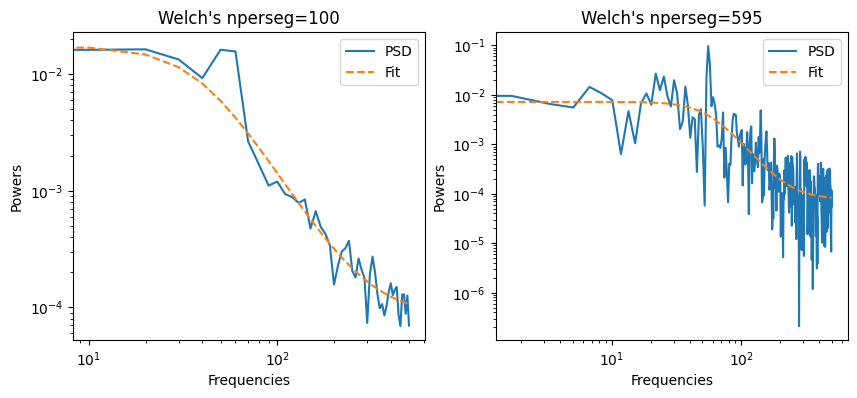

In [5]:
# Welch's
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

wf.results[0][1][0].plot(ax=axes[0])
wf.results[0][1][-1].plot(ax=axes[1])

axes[0].set_title(f"Welch's nperseg={nperseg[0]}")
axes[1].set_title(f"Welch's nperseg={nperseg[-1]}");

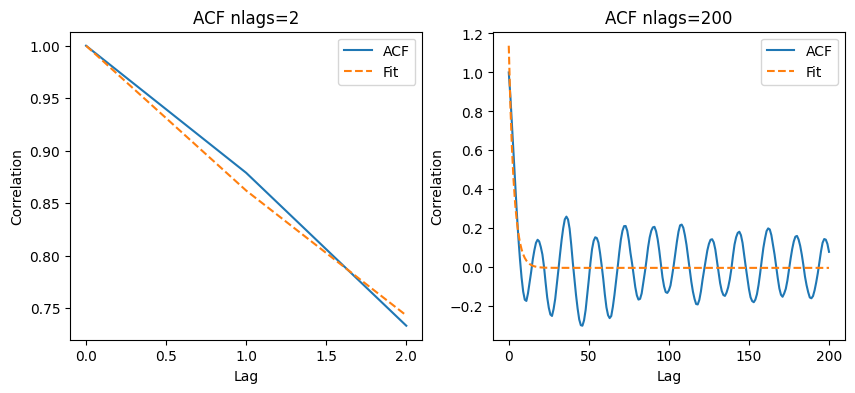

In [6]:
# ACF
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

wf.results[0][2][0].plot(ax=axes[0])
wf.results[0][2][-1].plot(ax=axes[1])

axes[0].set_title(f"ACF nlags={nlags[0]}")
axes[1].set_title(f"ACF nlags={nlags[-1]}");

## Results
### Comparison Between Model Types

In [7]:

def plot_results(x, y):
    
    fig, host = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches

    ax2 = host.twiny()
    ax3 = host.twiny()
    
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    
    ax3.xaxis.set_ticks_position("bottom")
    ax3.xaxis.set_label_position("bottom")
    
    
    color1, color2, color3 = plt.cm.viridis([0, .5, .9])

    p1 = host.scatter(x[0], y[0], label="Welch", color='C0')
    p2 = ax2.scatter(x[1], y[1], label="AR", color='C1')
    p3 = ax3.scatter(x[2], y[2], label="ACF", color='C2')
    
    host.legend(handles=[p1, p2, p3], loc='best')
    
    ax2.spines["bottom"].set_position(("axes", -0.15))
    ax3.spines["bottom"].set_position(("axes", -0.30))
    
    host.set_xlabel('Welch: nperseg')
    ax2.set_xlabel('AR: order')
    ax3.set_xlabel('ACF: nlags')
    
    host.xaxis.label.set_color(p1.get_facecolor())
    ax2.xaxis.label.set_color(p2.get_facecolor())
    ax3.xaxis.label.set_color(p3.get_facecolor())
    
    host.set_ylabel("MSE")
    
    plt.title('Timescale Estimation Bias')
    
    return fig, host

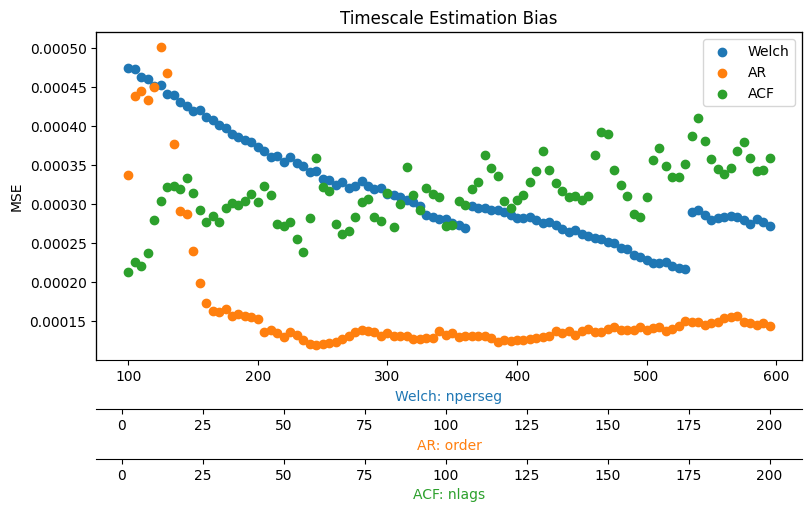

In [10]:
# True taus
taus = np.zeros(len(seeds))
for i, s in enumerate(seeds):
    np.random.seed(s)
    taus[i] = 1 / (2 * np.pi * np.random.uniform(1, 40))
    
# Unpack results
results_ar = np.array([[model.tau for model in i] for i in wf.results[:, 0]])
results_welch = np.array([[model.tau for model in i] for i in wf.results[:, 1]])
results_acf = np.array([[model.tau for model in i] for i in wf.results[:, 2]])

# Mean MSE
mse_welch = ((results_welch - taus[:, None])**2).mean(axis=0)
mse_ar = ((results_ar - taus[:, None])**2).mean(axis=0)
mse_acf = ((results_acf - taus[:, None])**2).mean(axis=0)
fig, host = plot_results([nperseg, order, nlags], [mse_welch, mse_ar, mse_acf])

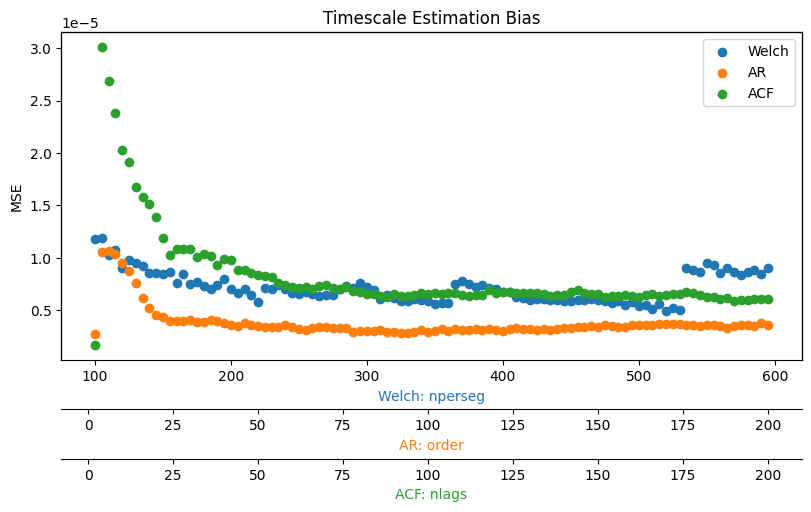

In [15]:
# Median MSE
mse_welch = np.median((results_welch - taus[:, None])**2, axis=0)
mse_ar = np.median((results_ar - taus[:, None])**2, axis=0)
mse_acf = np.median((results_acf - taus[:, None])**2, axis=0)
fig, host = plot_results([nperseg, order, nlags], [mse_welch, mse_ar, mse_acf])

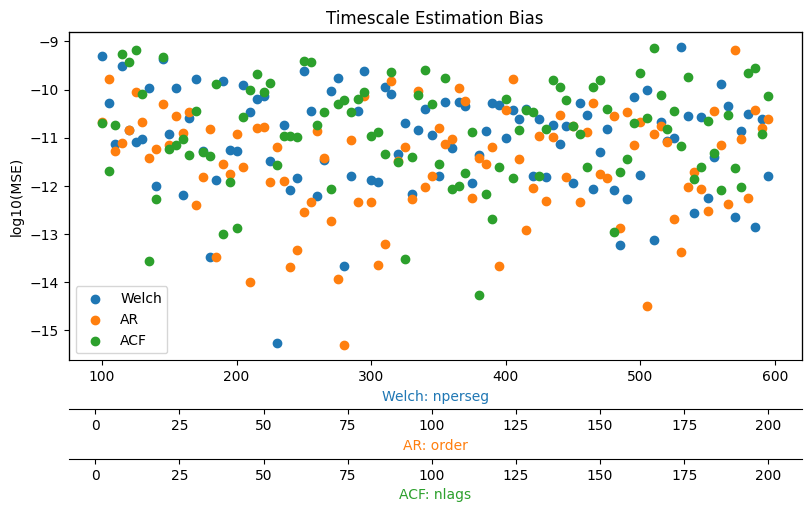

In [16]:
mse_welch = ((results_welch - taus[:, None])**2).min(axis=0)
mse_ar = ((results_ar - taus[:, None])**2).min(axis=0)
mse_acf = ((results_acf - taus[:, None])**2).min(axis=0)

fig, host = plot_results([nperseg, order, nlags], np.log10([mse_welch, mse_ar, mse_acf]))
host.set_ylabel("log10(MSE)");